# 1. Introduction of Essential Tools and Libraries
* ### IPython Notebook
    > Kernel: IPython is an alternative Python command line shell for interactive computing with lots of useful enhancements over the "default" Python interpreter.  

    > Jupyter: The browser-based documents Jupyter Notebook is a great environment for scientific computing: Not only to execute code, but also to add informative documentation via Markdown, HTML, LaTeX, embedded images, and inline data plots.

* ### Numpy
    > NumPy, short for Numerical Python. It provides the data structures, algorithms, and library glue needed for most scientific applications involving numerical data in Python. NumPy contains, among other things:
    >* A fast and efficient multidimensional array object ndarray
    >* Functions for performing element-wise computations with arrays or mathematical operations between arrays
    >* Tools for reading and writing array-based datasets to disk
    >* Linear algebra operations, Fourier transform, and random number generation
    >* A mature C API to enable Python extensions and native C or C++ code to access NumPy’s data structures and computational facilities

    > Beyond the fast array-processing capabilities that NumPy adds to Python, one of its primary uses in data analysis is as a container for data to be passed between algorithms and libraries.  

* ### Matplotlib
    > Matplotlib is the most popular Python library for data visualizations which can generate plots, histograms, power spectra, bar charts, error charts, scatter plots, etc., with just a few lines of code. It will helps us to make easy things easy and hard things possible.
    
* ### Seaborn
    > Seaborn is a library for making attractive and informative statistical graphics in Python. It aims to make visualization a central part of exploring and understanding data. And it is built on top of matplotlib and tightly integrated with the PyData stack, including support for numpy and pandas data structures and statistical routines from scipy and statsmodels.

* ### Scikit-learn
    > Scikit-learn is is the most popular general machine library for Python. It includes a broad range of different classifiers, cross-validation and other model selection methods, dimensionality reduction techniques, modules for regression and clustering analysis, and a useful data-preprocessing module.
    
* ### Scikit-image
    > scikit-image is a collection of algorithms for image processing.

In [1]:
# Face datasets from sklearn
from sklearn.datasets import fetch_lfw_people

# import GridSearchCV for Cross-validation and gridsearch
from sklearn.model_selection import GridSearchCV

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcdefaults()

# ndarray
import numpy as np

# For measure time cost
from time import time

# import Classification report and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# 2. Implementation

## Data Collection

In [2]:
ori_faces = fetch_lfw_people(min_faces_per_person=80)

n_sample, h, w = ori_faces.images.shape
n_features = ori_faces.data.shape[1]
data_shape = ori_faces.data.shape
target_names = ori_faces.target_names
n_classes = len(target_names)

print('Total number of sample: {}'.format(n_sample))
print('Image size: {} x {}'.format(h, w))
print("Total features per IMG: {}".format(n_features))
print("DataFrame shape: {}".format(data_shape))
print('Target names: {}'.format(target_names))
print('Total classes: {}'.format(n_classes))

Total number of sample: 1140
Image size: 62 x 47
Total features per IMG: 2914
DataFrame shape: (1140, 2914)
Target names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
Total classes: 5


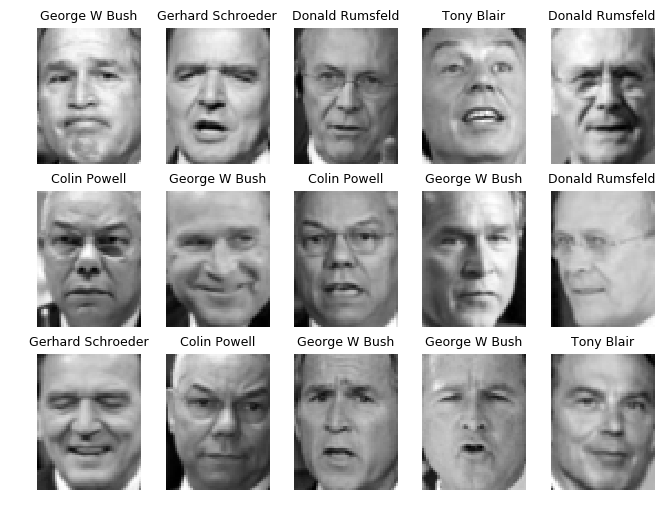

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))

for i, axi in enumerate(ax.flat):
    axi.imshow(ori_faces.images[i], cmap='gray')
    axi.set_title(ori_faces.target_names[ori_faces.target[i]], fontsize=9)
    axi.axis('off')
plt.show()

## Split datasets into Train & Test

In [4]:
from sklearn.model_selection import train_test_split

st_time = time()

X_train, X_test, y_train, y_test = train_test_split(
    ori_faces.data, 
    ori_faces.target,
    random_state=42 # random_state is the seed used by the random number generator
)

print('Size of training sets: {}'.format(X_train.shape[0]))
print('Size of Testing sets: {}'.format(X_test.shape[0]))

print('Done in: {:0.3f}s'.format(time()-st_time))

Size of training sets: 855
Size of Testing sets: 285
Done in: 0.010s


## HOG Feature Extraction

/Users/AlexChen/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


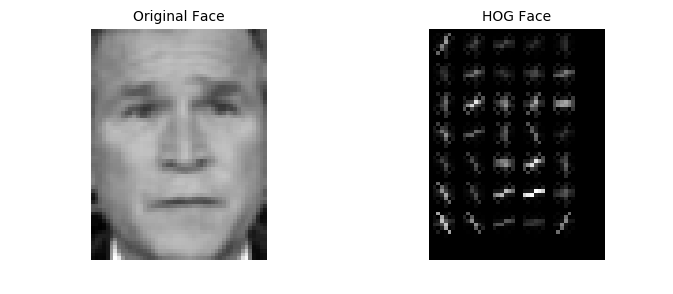

In [5]:
from skimage.feature import hog

X_train_hog = np.zeros(X_train.shape)
X_test_hog = np.zeros(X_test.shape)

for i in range(X_train.shape[0]):
    hog_vec, hog_vis = hog(X_train[i].reshape(h,w), visualise=True)
    X_train_hog[i] = hog_vis.flat
for i in range(X_test.shape[0]):
    hog_vec, hog_vis = hog(X_test[i].reshape(h,w), visualise=True)
    X_test_hog[i] = hog_vis.flat

fig, ax = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)

ax[0].imshow(X_train[0].reshape(h,w), cmap='gray')
ax[0].set_title('Original Face', fontsize=10)
ax[0].axis('off')

ax[1].imshow(X_train_hog[0].reshape(h,w), cmap='gray')
ax[1].set_title('HOG Face', fontsize=10)
ax[1].axis('off')

plt.show()

## PCA Feature Extraction

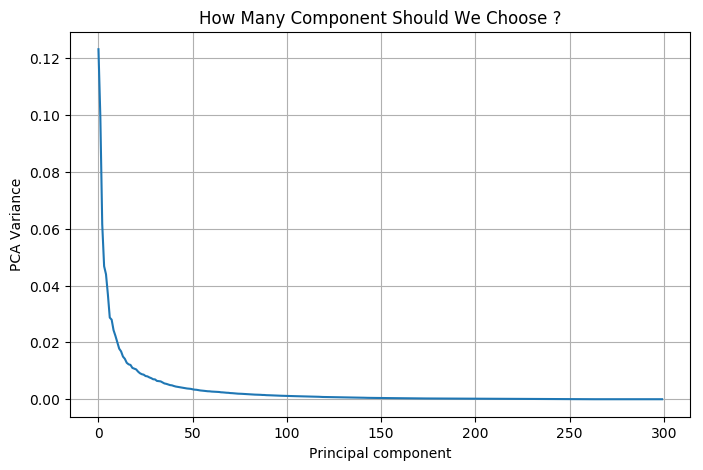

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300, svd_solver='randomized', whiten=True).fit(X_train_hog)

plt.figure(figsize=(8,5))
plt.plot(pca.explained_variance_ / sum(pca.explained_variance_))
plt.xlabel('Principal component')
plt.ylabel('PCA Variance')
plt.title('How Many Component Should We Choose ?')
plt.grid(True)
plt.show()

In [7]:
st_time = time()

n_components = 200

print("Extracting the top {} component from HOG train set of {} faces.".format(n_components, X_train_hog.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train_hog)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)

print('Done in: {:0.3f}s'.format(time()-st_time))

Extracting the top 200 component from HOG train set of 855 faces.
Done in: 0.877s


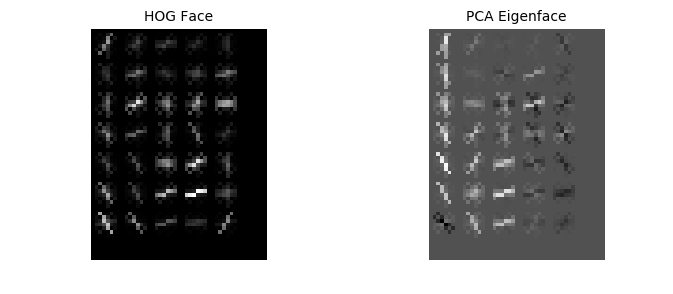

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)

ax[0].imshow(X_train_hog[0].reshape(h,w), cmap='gray')
ax[0].set_title('HOG Face', fontsize=10)
ax[0].axis('off')

ax[1].imshow(eigenfaces[0], cmap='gray')
ax[1].set_title('PCA Eigenface',fontsize=10)
ax[1].axis('off')
plt.show()

## Classification
> Support Vector Machine --> SVM  
> K Nearest Neighbors -- > KNN  
> Multi-Layer Perceptron --> MLP  

## GridSearchCV & Cross-Validation
> 5 fold validation: cv = 5


### Support Vector Classificaton

In [9]:
from sklearn.svm import SVC

st_time = time()

param_grid_svc = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']} 
]

# cv for cross-validation
svc = GridSearchCV(SVC(class_weight='balanced'), param_grid_svc, cv=5)

svc = svc.fit(X_train_pca, y_train)
svc_predict = svc.predict(X_test_pca)
svc_accuracy = accuracy_score(y_test, svc_predict)*100

print('Best parameters set for SVC: ')
print(svc.best_params_)
print('-------------------------------------------------------')
print('Accuracy Score: {:0.3f}%'.format(svc_accuracy))
print('-------------------------------------------------------')
print('Classification Report for SVC: ')
print(classification_report(y_test, svc_predict))
print('-------------------------------------------------------')
print('Done in: {:0.3f}s'.format(time()-st_time))

Best parameters set for SVC: 
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
-------------------------------------------------------
Accuracy Score: 87.368%
-------------------------------------------------------
Classification Report for SVC: 
             precision    recall  f1-score   support

          0       0.94      0.92      0.93        64
          1       0.81      0.78      0.79        32
          2       0.92      0.89      0.90       127
          3       0.84      0.72      0.78        29
          4       0.72      0.94      0.82        33

avg / total       0.88      0.87      0.87       285

-------------------------------------------------------
Done in: 16.867s


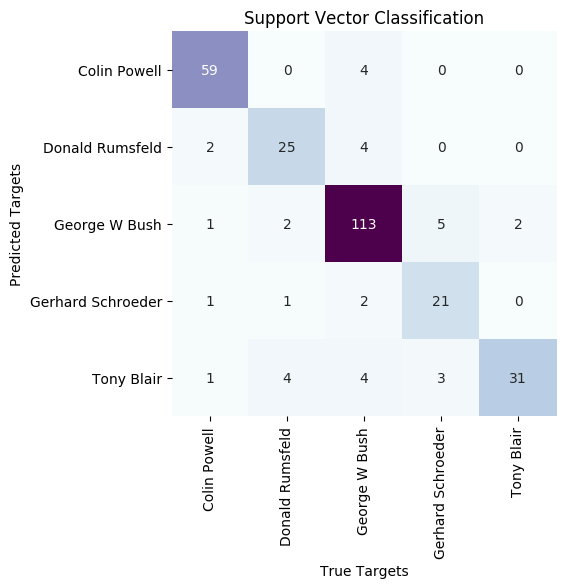

In [10]:
mat = confusion_matrix(y_test, svc_predict)

plt.figure(figsize=(8,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="BuPu")
plt.title('Support Vector Classification')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets')
plt.show()

### K Nearest Neighbors

In [11]:
from sklearn import neighbors

st_time = time()

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}

knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid_knn, cv=5)
knn.fit(X_train_pca, y_train)
knn_predict = knn.predict(X_test_pca)
knn_accuracy = accuracy_score(y_test, knn_predict)*100

print('Best parameters set for KNN: ')
print(knn.best_params_)
print('-------------------------------------------------------')
print('Accuracy Score: {:0.3f}%'.format(knn_accuracy))
print('-------------------------------------------------------')
print('Classification Report for KNN: ')
print(classification_report(y_test, knn_predict))
print('-------------------------------------------------------')
print('Done in: {:0.3f}s'.format(time()-st_time))

Best parameters set for KNN: 
{'n_neighbors': 5}
-------------------------------------------------------
Accuracy Score: 65.614%
-------------------------------------------------------
Classification Report for KNN: 
             precision    recall  f1-score   support

          0       0.76      0.61      0.68        64
          1       0.79      0.34      0.48        32
          2       0.61      0.94      0.74       127
          3       0.73      0.28      0.40        29
          4       0.69      0.27      0.39        33

avg / total       0.69      0.66      0.62       285

-------------------------------------------------------
Done in: 5.294s


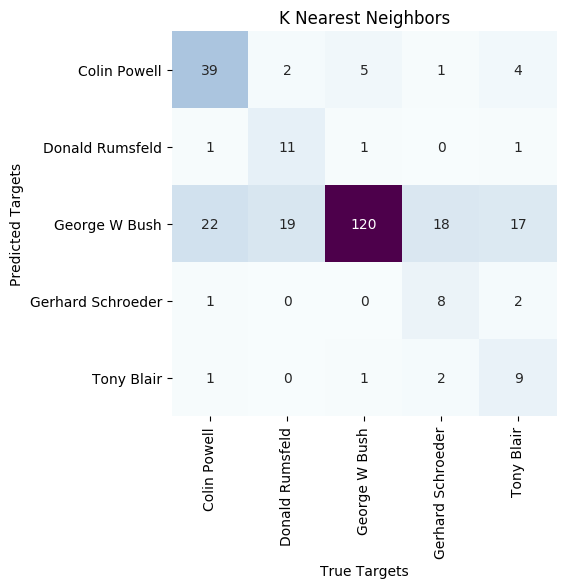

In [16]:
mat = confusion_matrix(y_test, knn_predict)

plt.figure(figsize=(8,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="BuPu")
plt.title('K Nearest Neighbors')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets')
plt.show()

### Multi-Layer Perceptron



> Too small number of hidden_layer_sizes may not be sufficient to learn complex decision boundaries.  
> Too large number of hidden_layer_sizes may overfit the training data resulting in poor generalization.  

In [13]:
from sklearn.neural_network import MLPClassifier

st_time = time()

param_grid_mlp = {
    'hidden_layer_sizes': [10, 50, 100, 125, 150, 175, 200]
}

mlp = GridSearchCV(MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, random_state=42), param_grid_mlp, cv=5)

mlp.fit(X_train_pca, y_train)
mlp_predict = mlp.predict(X_test_pca)
mlp_accuracy = accuracy_score(y_test, mlp_predict)*100

print('Best parameters set for MLP: ')
print(mlp.best_params_)
print('-------------------------------------------------------')
print('Accuracy Score: {:0.3f}%'.format(mlp_accuracy))
print('-------------------------------------------------------')
print('Classification Report for MLP: ')
print(classification_report(y_test, mlp_predict))
print('-------------------------------------------------------')
print('Done in: {:0.3f}s'.format(time()-st_time))

Best parameters set for MLP: 
{'hidden_layer_sizes': 150}
-------------------------------------------------------
Accuracy Score: 89.474%
-------------------------------------------------------
Classification Report for MLP: 
             precision    recall  f1-score   support

          0       0.97      0.91      0.94        64
          1       0.82      0.84      0.83        32
          2       0.91      0.91      0.91       127
          3       0.85      0.79      0.82        29
          4       0.82      0.94      0.87        33

avg / total       0.90      0.89      0.90       285

-------------------------------------------------------
Done in: 3.753s


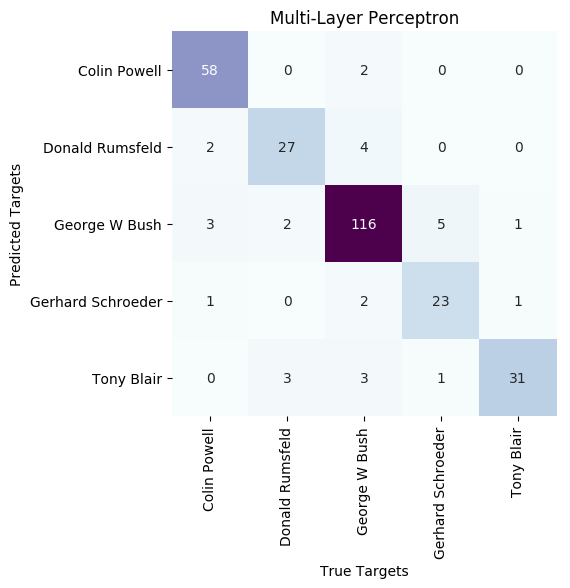

In [14]:
mat = confusion_matrix(y_test, mlp_predict)

plt.figure(figsize=(8,5))
# sns.set(font_scale=1.3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="BuPu")
plt.title('Multi-Layer Perceptron')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets')
plt.show()

## 3. Conclusion

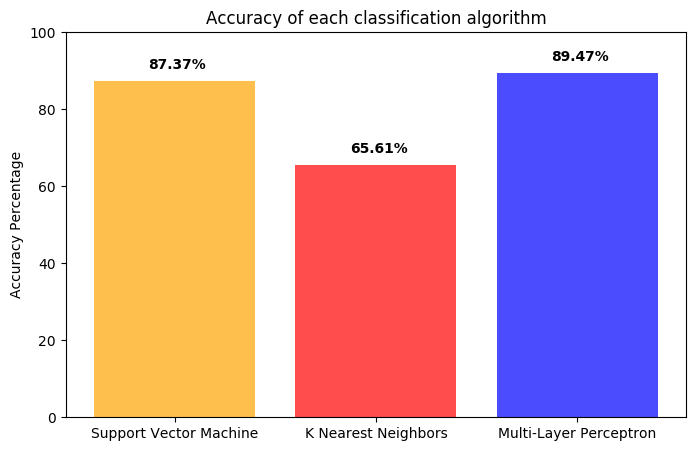

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
pca_objects = ('Support Vector Machine', 'K Nearest Neighbors', 'Multi-Layer Perceptron')
y_pos = np.arange(len(pca_objects))
colors = ('orange', 'red', 'blue')
pca_accuracy = [svc_accuracy, knn_accuracy, mlp_accuracy]

ax.bar(y_pos, pca_accuracy, align='center', color=colors, alpha=0.7, tick_label=pca_objects)
ax.set_ylabel('Accuracy Percentage')
ax.set_ylim(0, 100)
ax.set_title('Accuracy of each classification algorithm')

for i, v in enumerate(pca_accuracy):
    ax.text(i - 0.13, v + 3, str(format(v, '0.2f'))+'%', color='black', fontweight='bold')
plt.show()